In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
from matplotlib.externals import six
import mpld3
mpld3.enable_notebook()

## Variables used in calculations

In [19]:
avg_cons = 23260  #Average consumption of gas in kWh for a family of 2 parents and 1 child

## Reading in the data

In [20]:
df = pandas.read_csv("gas_vreg.csv")
df = df.drop(['year','Month','Day','h','From','To'], 1)
df['cons_kWh'] = df.apply(lambda row: row['Cons_percentage']*avg_cons*5, axis=1)

In [21]:
df.head()

UTC  Cons_percentage   cons_kWh
0  1/1/2017 5:00         0.000241  28.003307
1  1/1/2017 6:00         0.000321  37.341360
2  1/1/2017 7:00         0.000375  43.609674
3  1/1/2017 8:00         0.000369  42.886660
4  1/1/2017 9:00         0.000342  39.743490

In [22]:
df.describe()

Cons_percentage     cons_kWh
count      8760.000000  8760.000000
mean          0.000114    13.276256
std           0.000099    11.560460
min           0.000011     1.227267
25%           0.000025     2.952505
50%           0.000082     9.530372
75%           0.000189    21.967125
max           0.000392    45.579342

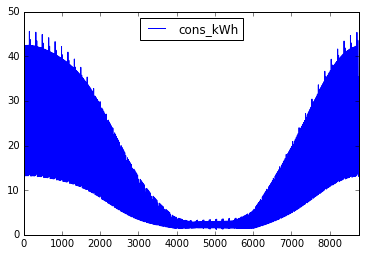

In [23]:
time_data = df[['UTC','cons_kWh']]
time_data.plot()

               UTC   cons_kWh
0    1/7/2017 7:00  45.579342
1   1/14/2017 7:00  45.378783
2  12/30/2017 7:00  45.338520
3   1/21/2017 7:00  44.865400
4  12/23/2017 7:00  44.639057


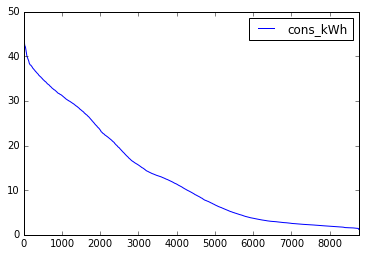

In [37]:
time_data_sorted = time_data.sort_values('cons_kWh', ascending=False)
index = 0
sorted_frame = time_data_sorted.reset_index(drop=True)
print sorted_frame.head()
sorted_frame.plot()
#ax = sorted_frame.plot()
#fig = ax.get_figure()
#fig.savefig("load_profile.png", dpi=900)

## Buffer calculations

### Variables

In [25]:
generator_power = 5000                           #Power in Wh (we do all our calculations in hours)
buffer_size = 1000                               #buffer size in liters
buffer_energy = buffer_size*4.2*20/3.6           #Calculation of energy stored in full buffer 
                                                 #(which we assume at the beginning of calculations)
#4.2 caloric value of water, 20 is delta t, 3.6 is Joule to Watt conversion factor
max_buffer_energy = buffer_energy

#TODO calculate buffer, extra needed heat, 

### Calculation for system without extra heating source

In [26]:
data = df
for index, row in data.iterrows():
    #print row['UTC'],"\t\t", row['cons_kWh']
    demand = row['cons_kWh']*1000     #times 1000 for conversion to Wh
    extra_needed = demand - generator_power   #remaining demand that can't be supplied by generator
    
    
    if demand >= generator_power:          #demand is bigger than provided by generator, we will need an external heat source
        data.set_value(index,'extra_needed',extra_needed)  #store extra_needed value in dataframe
        if(buffer_energy >= extra_needed):     #has the buffer enough energy stored to supply the extra demand?
            buffer_energy -= extra_needed
        else:
            external_needed = extra_needed - buffer_energy
            buffer_energy = 0       #buffer completely drained
    else:                                  #demand can be fully provided by generator, we will fill the buffer
        buffer_energy += generator_power - demand
        data.set_value(index,'extra_needed',0)
        if buffer_energy > max_buffer_energy:
            buffer_energy = max_buffer_energy
    
    
    data.set_value(index,'buffer_energy_now',buffer_energy)
    
data.head()

UTC  Cons_percentage   cons_kWh  extra_needed  buffer_energy_now
0  1/1/2017 5:00         0.000241  28.003307   23003.30713         330.026203
1  1/1/2017 6:00         0.000321  37.341360   32341.35977           0.000000
2  1/1/2017 7:00         0.000375  43.609674   38609.67391           0.000000
3  1/1/2017 8:00         0.000369  42.886660   37886.66007           0.000000
4  1/1/2017 9:00         0.000342  39.743490   34743.48975           0.000000

### Calculation with extra heat source (CHP 10-50 kW)

In [34]:
min_CHP = 1
max_CHP = 20000
generator_power = 5000                           #Power in Wh (we do all our calculations in hours)
buffer_size = 6000                               #buffer size in liters
buffer_energy = buffer_size*4.2*20/3.6           #Calculation of energy stored in full buffer 
                                                 #(which we assume at the beginning of calculations)
#4.2 caloric value of water, 20 is delta t, 3.6 is Joule to Watt conversion factor
max_buffer_energy = buffer_energy


data_CHP = df

for index, row in data_CHP.iterrows():
    demand = row['cons_kWh']*1000     #times 1000 for conversion to Wh
    waste_energy = 0
    if demand <= generator_power:       #CHP unit is not turned on, except maybe to fill buffer (but let's not do that for now)
        excess_heat = generator_power - demand
        buffer_energy += excess_heat
        if buffer_energy > max_buffer_energy:
            waste_energy = buffer_energy - max_buffer_energy
            buffer_energy = max_buffer_energy
        data_CHP.set_value(index, 'CHP_prod', 0)
    else:
        extra_needed = demand - generator_power
        if extra_needed <= buffer_energy:
            #supply extra heat from buffer
            buffer_energy -= extra_needed   
            data_CHP.set_value(index, 'CHP_prod', 0)
        else: #buffer alone can't supply the nescessary extra heat
            #empty buffer
            extra_needed -= buffer_energy
            buffer_energy = 0
            #use CHP to supply the extra heat
            #if the extra heat is below the CHP threshold use this excess heat to fill the buffer again
            if extra_needed <= min_CHP:
                excess_heat = min_CHP - extra_needed
                data_CHP.set_value(index, 'CHP_prod', min_CHP)
                #store excess heat in the buffer
                buffer_energy += excess_heat
                if buffer_energy > max_buffer_energy:
                    waste_energy = buffer_energy - max_buffer_energy
                    buffer_energy = max_buffer_energy
            else:
                if extra_needed > max_CHP:
                    print "CHP unit can't supply sufficient energy at time: ", row['UTC']
                    data_CHP.set_value(index, 'CHP_prod', max_CHP)
                else:
                    #fill buffer if possible
                    left_to_fill_buffer = max_CHP-extra_needed                    
                    if(left_to_fill_buffer > max_buffer_energy):
                        left_to_fill_buffer = max_buffer_energy                       
                    buffer_energy = left_to_fill_buffer
                    data_CHP.set_value(index, 'CHP_prod', extra_needed+left_to_fill_buffer)
    data_CHP.set_value(index,'waste_energy', waste_energy)        
    data_CHP.set_value(index,'buffer_energy_now',buffer_energy)
data_CHP.head()

CHP unit can't supply sufficient energy at time:  1/1/2017 9:00
CHP unit can't supply sufficient energy at time:  1/1/2017 10:00
CHP unit can't supply sufficient energy at time:  1/1/2017 11:00
CHP unit can't supply sufficient energy at time:  1/1/2017 12:00
CHP unit can't supply sufficient energy at time:  1/1/2017 13:00
CHP unit can't supply sufficient energy at time:  1/1/2017 14:00
CHP unit can't supply sufficient energy at time:  1/1/2017 15:00
CHP unit can't supply sufficient energy at time:  1/1/2017 16:00
CHP unit can't supply sufficient energy at time:  1/1/2017 17:00
CHP unit can't supply sufficient energy at time:  1/1/2017 18:00
CHP unit can't supply sufficient energy at time:  1/1/2017 19:00
CHP unit can't supply sufficient energy at time:  1/1/2017 20:00
CHP unit can't supply sufficient energy at time:  1/2/2017 5:00
CHP unit can't supply sufficient energy at time:  1/2/2017 6:00
CHP unit can't supply sufficient energy at time:  1/2/2017 7:00
CHP unit can't supply suffici

UTC  Cons_percentage   cons_kWh  extra_needed  buffer_energy_now  \
0  1/1/2017 5:00         0.000241  28.003307   23003.30713       116996.69287   
1  1/1/2017 6:00         0.000321  37.341360   32341.35977        84655.33310   
2  1/1/2017 7:00         0.000375  43.609674   38609.67391        46045.65919   
3  1/1/2017 8:00         0.000369  42.886660   37886.66007         8158.99912   
4  1/1/2017 9:00         0.000342  39.743490   34743.48975            0.00000   

   CHP_prod  waste_energy  CHP_prod_one  CHP_prod_two  
0         0             0             0             0  
1         0             0             0             0  
2         0             0         20000         20000  
3         0             0         20000         20000  
4     20000             0         20000             0

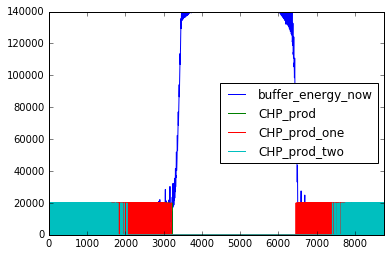

In [35]:
check_CHP_behaviour = data_CHP
check_CHP_behaviour = check_CHP_behaviour.drop(['Cons_percentage','cons_kWh', 'extra_needed', 'waste_energy'], 1)
ax = check_CHP_behaviour.plot()
fig = ax.get_figure()
fig.savefig("buffer_and_waste.png")

### Checking if there was any waste energy that needed pumping it into the river

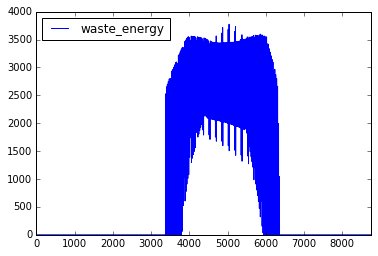

In [29]:
temp_waste = data_CHP
temp_waste = temp_waste.drop(['Cons_percentage','cons_kWh', 'extra_needed', 'buffer_energy_now', 'CHP_prod'], 1)
temp_waste.plot()

#check_waste_energy = data_CHP[data_CHP.waste_energy != 0]
#check_waste_energy = check_waste_energy.drop(['Cons_percentage','cons_kWh', 'extra_needed', 'buffer_energy_now', 'CHP_prod'], 1)
#check_waste_energy.head()

### Checking if the CHP unit needs to turn on or off a lot

In [30]:
temp_df = data_CHP
on_time = 0
CHP_on = False
counter = [0,0,0,0,0,0,0,0,0,0,0]
longterm = 0
for index, row in temp_df.iterrows():
    if row['CHP_prod'] > 0:
        if CHP_on != True:
            CHP_on = True
        on_time += 1
    else:
        if CHP_on:
            CHP_on = False
            #print row['UTC'], ": CHP has turned off after ", on_time, " hours"
            temp = on_time
            if on_time > 10:
                temp = 11
                longterm += on_time
            counter[temp-1] += 1
            on_time = 0
for i in range(len(counter)):
    print i+1, " hours: ", counter[i], "x"
print longterm

1  hours:  573 x
2  hours:  65 x
3  hours:  19 x
4  hours:  14 x
5  hours:  10 x
6  hours:  15 x
7  hours:  11 x
8  hours:  12 x
9  hours:  4 x
10  hours:  3 x
11  hours:  117 x
2198


#### TODO: balance calculations, integrate solar/..., check buffer size for extra power of 40-45-50-.. kW

## 2 CHP units of each 20kW 

In [31]:
CHP_one = 20000
CHP_two = 20000
generator_power = 5000                           #Power in Wh (we do all our calculations in hours)
buffer_size = 3000                               #buffer size in liters
buffer_energy = buffer_size*4.2*20/3.6           #Calculation of energy stored in full buffer 
                                                 #(which we assume at the beginning of calculations)
#4.2 caloric value of water, 20 is delta t, 3.6 is Joule to Watt conversion factor
max_buffer_energy = buffer_energy


data_CHP_dual = df

for index, row in data_CHP_dual.iterrows():
    demand = row['cons_kWh']*1000     #times 1000 for conversion to Wh
    waste_energy = 0
    if demand <= generator_power:       #CHP unit is not turned on, except maybe to fill buffer (but let's not do that for now)
        excess_heat = generator_power - demand
        buffer_energy += excess_heat
        if buffer_energy > max_buffer_energy:
            waste_energy = buffer_energy - max_buffer_energy
            buffer_energy = max_buffer_energy
   
        data_CHP_dual.set_value(index, 'CHP_prod_one', 0)
        data_CHP_dual.set_value(index, 'CHP_prod_two', 0)    
    else:
        #extra heat needs to be provided, either by buffer, CHP units or both
        #1: buffer can provide enough energy to supply demand        
        #2: buffer can't provide enough
            #2.1: one CHP unit is added to the mix, excess produced heat is stored in buffer            
            #2.2: two CHP or more units are needed            
            #2.3: all CHP units are working but demand couldn't be supplied
        extra_needed = demand - generator_power
        if extra_needed <= buffer_energy:
            buffer_energy -= extra_needed   
            data_CHP_dual.set_value(index, 'CHP_prod_one', 0)
            data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
        else: #buffer alone can't supply the nescessary extra heat 
            extra_needed -= buffer_energy
            buffer_energy = 0
            
            if extra_needed <= CHP_one:
                excess_heat = CHP_one - extra_needed
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
                #store excess heat in the buffer
                buffer_energy += excess_heat
                if buffer_energy > max_buffer_energy:
                    waste_energy = buffer_energy - max_buffer_energy
                    buffer_energy = max_buffer_energy
            elif extra_needed > CHP_one and extra_needed <= CHP_one + CHP_two:
                excess_heat = CHP_one + CHP_two - extra_needed
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', CHP_two)
                #store excess heat in the buffer
                buffer_energy += excess_heat
                if buffer_energy > max_buffer_energy:
                    waste_energy = buffer_energy - max_buffer_energy
                    buffer_energy = max_buffer_energy
            else:
                print "CHP unit can't supply sufficient energy at time: ", row['UTC']
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', CHP_two)
            
        
    data_CHP_dual.set_value(index,'waste_energy', waste_energy)        
    data_CHP_dual.set_value(index,'buffer_energy_now',buffer_energy)
data_CHP_dual.head()

UTC  Cons_percentage   cons_kWh  extra_needed  buffer_energy_now  \
0  1/1/2017 5:00         0.000241  28.003307   23003.30713        46996.69287   
1  1/1/2017 6:00         0.000321  37.341360   32341.35977        14655.33310   
2  1/1/2017 7:00         0.000375  43.609674   38609.67391        16045.65919   
3  1/1/2017 8:00         0.000369  42.886660   37886.66007        18158.99912   
4  1/1/2017 9:00         0.000342  39.743490   34743.48975         3415.50937   

   CHP_prod  waste_energy  CHP_prod_one  CHP_prod_two  
0         0             0             0             0  
1         0             0             0             0  
2     20000             0         20000         20000  
3     20000             0         20000         20000  
4     20000             0         20000             0

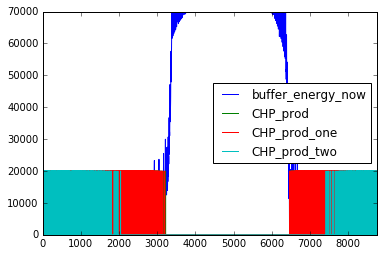

In [32]:
check_dual_CHP_behaviour = data_CHP_dual
check_dual_CHP_behaviour = check_dual_CHP_behaviour.drop(['Cons_percentage','cons_kWh', 'extra_needed', 'waste_energy'], 1)
check_dual_CHP_behaviour.plot()

In [33]:
temp_df = data_CHP_dual
on_time_one = 0
on_time_two = 0
CHP_on_one = False
CHP_on_two = False
counter_one = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
counter_two = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
longterm = 0
for index, row in temp_df.iterrows():
    if row['CHP_prod_one'] > 0:
        if CHP_on_one != True:
            CHP_on_one = True
        on_time_one += 1
        if row['CHP_prod_two'] > 0:
            if CHP_on_two != True:
                CHP_on_two = True
            on_time_two += 1
    else:
        if CHP_on_one:
            if CHP
            #print row['UTC'], ": CHP has turned off after ", on_time, " hours"
            temp_one = on_time_one
            temp_two = on_time_two
            if on_time_one > len(counter_one) - 2:
                temp_one = len(counter_one) - 2
                longterm += on_time_one
            counter[temp-1] += 1
            on_time_one = 0
            CHP_on_one = False
            CHP_on_two = False
for i in range(len(counter)):
    print i+1, " hours: ", counter[i], "x"
print longterm

SyntaxError: invalid syntax (<ipython-input-33-db10139356b4>, line 20)

In [ ]:
df